# Emotiv - Resting and headrolls EEG Quality Index

## Import libraries

In [1]:
#%% Import libraries
import os
import mne
import sys
import time
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.collections as collections
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import artifact_removal_tools as art
from Functions import eeg_preprocessing
from Functions import eeg_quality_index
from IPython.display import clear_output

## Import data

In [2]:
# File names to import
files = ['SSVEP_10Hz_LF_Mar23_EPOCX_126787_2021.03.23T17.18.27.06.00.edf', 'SSVEP_10Hz_OKB_Mar22_EPOCX_126582_2021.03.22T17.42.37.06.00.edf',
        'SSVEP_17Hz_LF_Mar23_EPOCX_126787_2021.03.23T17.20.48.06.00.edf', 'SSVEP_17Hz_OKB_Mar22_EPOCX_126582_2021.03.22T17.45.11.06.00.edf']
n_files = len(files)    

# Determine data folder
notebook_dir = os.getcwd()              # Notebook directory
os.chdir('..')                          # Move one folder up
main_dir = os.getcwd()                  # Main project directory
data_folder = main_dir + "\\Data"       # Data folder
os.chdir(notebook_dir)                  # Return to notebook directory

# EEG channel indices
ch_start = 4    # Channel start index [n]
ch_end = 18     # Channel end index [n]
eeg_ch_index = np.arange(ch_start, ch_end)

# Preallocate data
eeg_raw = [None] * n_files
srate = [None] * n_files
chans = [None] * n_files

for i,f in enumerate(files):
    temp_data = mne.io.read_raw_edf(data_folder+'\\'+f, verbose=False)
    eeg_raw[i] = temp_data.get_data(eeg_ch_index.tolist())
    srate[i] = temp_data.info['sfreq']
    chans[i] = temp_data.info['ch_names'][slice(ch_start, ch_end)]

# Use artifact removal tool

## Full dataset

In [3]:
# Filter settings
f_type = 'band'
fc = [1,30]     # Cut-off frequencies [Hz]
order = 4       # Filter order [n]

# Artifact removal tool settings
w_length = 0.9  # Window length [sec]
n_clusters = 10 # Number of clusters for k_means [n]

# Preallocate data
n_files = 1
eeg_pre = [None] * n_files  # Preprocessed EEG
eeg_art = [None] * n_files  # Artifact removed EEG

for i in range(n_files):
    eeg_pre[i] = eeg_preprocessing.filter(f_type, eeg_raw[i], fc, srate[i], order)
    eeg_art[i],_,_ = art.remove_eyeblinks_cpu(eeg_pre[i], srate[i], w_length, n_clusters)


### Plot RAW and cleaned data

IndexError: list index out of range

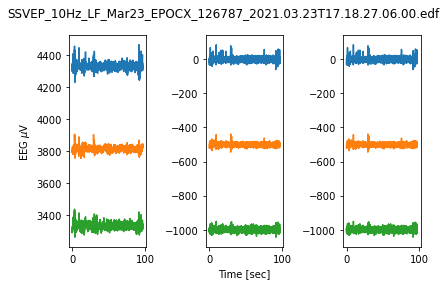

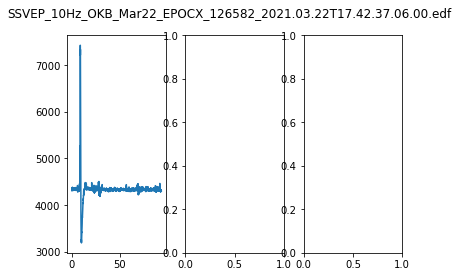

In [4]:
plot_data = True

plot_chans = [0,1,2]    # List of channels to plot
scale = 1e6            # Scale for EEG data [V]
offset = 500          # Offset to plot channels [V*scale]

if plot_data:
    for i,f in enumerate(files):
        fig,ax = plt.subplots(1, 3)
        fig.suptitle(f)
           
        len_trial = np.size(eeg_raw[i],1)
        temp_time = np.linspace(0, len_trial/srate[i], len_trial)

        for c in plot_chans:
            ax[0].plot(temp_time, eeg_raw[i][c,:]*scale - c*offset)
            ax[1].plot(temp_time, eeg_pre[i][c,:]*scale - c*offset)
            ax[2].plot(temp_time, eeg_art[i][c,:]*scale - c*offset)
            ax[1].set_xlabel('Time [sec]')
            ax[0].set_ylabel('EEG $\mu$V')
        plt.tight_layout()


### Windows

In [ ]:
# Preallocate data
eeg_pre_w = [None] * n_files  # Preprocessed EEG
eeg_art_w = [None] * n_files  # Artifact removed EEG
exec_time = [None] * n_files  # Execution times

w_art = 1   # Windows to process data, to simulate real-time [sec]

for i in range(n_files):
    temp_eeg = eeg_raw[i]
    n_chans = np.size(temp_eeg,0)

    # Reshape temp_eeg in windows of length w_art
    len_temp_eeg = np.size(temp_eeg,1)  # Length of trial [samples]
    len_window = int(w_art * srate[i])       # Length of window [samples]
    
    # - Trim data to full size windows
    if len_temp_eeg % len_window:
        trim = np.floor(len_temp_eeg/len_window) * srate[i]
        temp_eeg = temp_eeg[:,0:int(trim)]

    n_windows = np.floor_divide(len_temp_eeg, len_window)
    exec_time[i] = np.zeros((n_windows,3))
    temp_eeg_tensor = np.reshape(temp_eeg, [n_chans, len_window, -1])
    temp_pre_tensor = np.zeros_like(temp_eeg_tensor)
    temp_art_tensor = np.zeros_like(temp_eeg_tensor)

    for w in range(n_windows):
        exec_time[i][w,0] = time.time()
        temp_pre_tensor[:,:,w] = eeg_preprocessing.filter(f_type, temp_eeg_tensor[:,:,w], fc, srate[i], order)
        exec_time[i][w,1] = time.time()
        temp_art_tensor[:,:,w],_,_ = art.remove_eyeblinks_cpu(temp_pre_tensor[:,:,w], srate[i], w_length, n_clusters)
        exec_time[i][w,2] = time.time()

    eeg_pre_w[i] = np.reshape(temp_pre_tensor, [n_chans, -1])
    eeg_art_w[i] = np.reshape(temp_art_tensor, [n_chans, -1])

## Execution time

In [ ]:
test_exec_time = False  # Boolean to test execution time

if test_exec_time:
    for i,f in enumerate(files):
        print(f'File {f}\n{np.size(eeg_pre[i],0)} channels, {np.size(eeg_pre[i],1)/srate[i]:.2f} sec of data')    
        %timeit -n2 -r3 -o art.remove_eyeblinks_cpu(eeg_pre[i], srate[i], w_length, n_clusters)
        print('\n')

## EEG Quality Index

In [ ]:
[_, eqi_okb_pre, _] = eeg_quality_index.scoring(eeg_raw[3], eeg_raw[0], int(srate[3]), int(srate[0]), window=int(srate[0]), slide=10)
[_, eqi_okb_art, _] = eeg_quality_index.scoring(eeg_raw[3], eeg_art[0], int(srate[3]), int(srate[0]), window=int(srate[0]), slide=10)

[_, eqi_lf_pre, _] = eeg_quality_index.scoring(eeg_raw[2], eeg_raw[1], int(srate[2]), int(srate[1]), window=int(srate[1]), slide=10)
[_, eqi_lf_art, _] = eeg_quality_index.scoring(eeg_raw[2], eeg_art[1], int(srate[2]), int(srate[1]), window=int(srate[1]), slide=10)

# eqi_okb_channel = np.array([eqi_okb_pre[0], eqi_okb_art[0]]).T
# eqi_lf_channel = np.array([eqi_lf_pre[0], eqi_lf_art[0]]).T

In [ ]:
np.shape(eeg_pre[0])

In [ ]:
a = exec_time[1]
print(f'mean = {np.mean(a[:,2] - a[:,1])}')
print(f'std = {np.std(a[:,2] - a[:,1])}')

b = np.array([eqi_okb_pre[0], eqi_okb_art[0]]).T
c = np.diff(b,1,1)
d = eqi_okb_pre[2]

# Test classification improvements

Use the windowed versions of the data to test if the classification rate improves when applying the artifact removal tool